In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import shutil

In [12]:
from ultralytics import YOLO
model = YOLO("./training/last.pt")

In [26]:
result = [
     [
         [[[20.0, 20.0], [103.0, 20.0], [103.0, 34.0], [20.0, 34.0]], ('XEQUETDUONGDUO', 0.9368736147880554)], 
         [[[21.0, 35.0], [103.0, 39.0], [102.0, 56.0], [20.0, 52.0]], ('(TU22:00-5:00', 0.9210197925567627)], 
         [[[63.0, 60.0], [102.0, 60.0], [102.0, 76.0], [63.0, 76.0]], ('NGOAI', 0.9804909825325012)], 
         [[[65.0, 76.0], [103.0, 80.0], [102.0, 96.0], [63.0, 91.0]], ('Excep', 0.9797548055648804)]
     ]
] #resluts
for line in result[0]:
         print(line[1][0])
         print(line[1][1])

XEQUETDUONGDUO
0.9368736147880554
(TU22:00-5:00
0.9210197925567627
NGOAI
0.9804909825325012
Excep
0.9797548055648804


In [ ]:
from paddleocr import PaddleOCR
import cv2
import re
# test_folder = '/kaggle/working/results'
test_folder = "./results"
# !rm -rf ./results
# os.mkdir(test_folder)
CONFIDENCE_THRESHOLD = 0.5

# https://paddlepaddle.github.io/PaddleOCR/latest/en/quick_start.html#use-by-code
ocr = PaddleOCR(use_angle_cls = True, use_gpu = False)

def paddle_ocr(image, x1, y1, x2, y2):
    image = image[max(0, y1) : (y2), max(0, x1) : (x2)]
    # image = cv2.resize(image, (int(image.shape[1] * 1.1), int(image.shape[0] * 1.1)), interpolation=cv2.INTER_LINEAR) 
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # sharp = cv2.Laplacian(blurred, cv2.CV_64F)

    # thresh = cv2.adaptiveThreshold(sharp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    result = ocr.ocr(image, det=True, rec = True, cls = False)
    if result is None  or result[0] is None:
        return ""
    text = []
    print(result[0])
    for line in result[0]:
        l_text, scores = line[1][0], line[1][1]
        if np.isnan(scores):
            scores = 0
        else:  # threshold
            scores = int(scores * 100)
        if 50 < scores:
            text.append(l_text)
    text = " ".join(text)
    pattern = re.compile('[\W]')
    text = pattern.sub('', text)
    text = text.replace("???", "")
    text = text.replace("O", "0")
    text = text.replace("粤", "")

    # car plate: 7-8 characters
    if len(text) < 9:
        return str(text)
    else:
        return ""

def predict_ocr(image):
    """
        image: vehicle image was cropped
    """
    results = model.predict(image, device='cpu')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    if results is None:
        return ""
    # process for single vehicle
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])    # coordinates of plate
            return paddle_ocr(image, x1, y1, x2, y2)

    # process for multiple vehicle     
    # for result in results:
    #     filtered_boxes = [box for box in result.boxes if box.conf[0] > CONFIDENCE_THRESHOLD]
    #     for box in filtered_boxes:
    #         x1, y1, x2, y2 = map(int, box.xyxy[0])    # plate
    #         # confidence = box.conf[0]  # Get confidence
            
    #         # Crop bounding box
    #         # rect = image[y1:y2, x1:x2]
    #         # plt.imshow(rect)
    #         # print((x1, y1), (x2, y2))
    #         # text = paddle_ocr(image, x1, y1, x2, y2)
    #         return paddle_ocr(image, x1, y1, x2, y2)


    #         # print("NONE") if result==None else print(result)
    #         # text = result[0][0]
                    
    #         # print(f"Detected text: {confidence:.2f}_{text}")
    #         # cv2.putText(image, f'{confidence:.2f}_{text}', (x1-30, y1-10), 
    #         #         cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                    
    #         # cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

    #         # boxes = [elements[0] for elements in line for line in result]
    #         # txts = [elements[1][0] for elements in line for line in result]
    #         # scores = [elements[1][1] for elements in line for line in result]
    #         # output = draw_ocr(image, boxes, txts, scores, font_path='path_to_font.ttf')
            
    #         # # text = pytesseract.image_to_string(rect, config='--psm 6')  # perform OCR
    # return paddle_ocr(image, x1, y1, x2, y2)

def predict_folder(path_test):
    for img in os.listdir(path_test):
        image = cv2.imread(os.path.join(path_test, img))
        image = predict_ocr(image)
        cv2.imwrite(os.path.join(test_folder, img), image)
        
# predict_folder('/kaggle/input/demo-ttt')

[2025/03/20 10:16:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\FPT SHOP/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\FPT SHOP/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48,

In [ ]:
import cv2
# !rm -rf /kaggle/working/vid_results
# os.mkdir("/kaggle/working/vid_results")
video_path = "./data/test.mp4"
vidcap = cv2.VideoCapture(video_path)

model2 = YOLO("yolo12n.pt")
CONFIDENCE_THRESHOLD = 0.5

vidcap.set(cv2.CAP_PROP_FPS, 60)  
vidcap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280) 
vidcap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

fps = int(vidcap.get(cv2.CAP_PROP_FPS))  # Frames per second
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Độ rộng frame
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Chiều cao frame

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
output_path = './processed_vid.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

if not vidcap.isOpened():
    print("Error opening video stream")
    exit()

frame_count = 0
while True:
    success, frame = vidcap.read()
    if not success:
        break   
    results = model2.predict(frame, device='cpu', classes=[2, 3, 5, 7])
    for result in results:
        filtered_boxes = [box for box in result.boxes if box.conf[0] > CONFIDENCE_THRESHOLD ]
        for box in filtered_boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])   # (x1, y1), (x2, y2): coordinates of the vehicle
            confidence = box.conf[0]
            cls = int(box.cls[0])
            list_vehicle = {2: "car", 3: "motorbike", 5: "bus", 7: "truck"}
            name_vehicle = list_vehicle[cls]
            vehicle = frame[y1:y2, x1:x2]     # crop vehicle
            text = predict_ocr(vehicle)    # text: number plate
            # print(f"Detected text: {confidence:.2f}_{cls}_{text}")
            if text is not None:
                cv2.putText(frame, f'{confidence:.2f}_{name_vehicle}_{text}', (x1-10, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            else:
                cv2.putText(frame, f'{confidence:.2f}_{name_vehicle}', (x1-10, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # frame = predict_ocr(frame)
    # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(f"./results/frame_{frame_count}.jpg", frame)
    # frame = cv2.resize(frame, (960, 640))
    cv2.imshow("Video", frame)
    out.write(frame)
    frame_count += 1
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

vidcap.release()
out.release()

cv2.destroyAllWindows()


0: 480x640 4 cars, 15 motorcycles, 1 truck, 187.1ms
Speed: 8.1ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 1088x704 (no detections), 339.1ms
Speed: 6.9ms preprocess, 339.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1088, 704)

0: 1088x704 (no detections), 270.8ms
Speed: 5.7ms preprocess, 270.8ms inference, 0.6ms postprocess per image at shape (1, 3, 1088, 704)

0: 1088x672 (no detections), 319.1ms
Speed: 5.3ms preprocess, 319.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1088, 672)

0: 1024x1088 1 0, 483.2ms
Speed: 9.9ms preprocess, 483.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1088)
[2025/03/20 10:25:58] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.013956785202026367
[2025/03/20 10:25:58] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0

0: 1088x608 (no detections), 427.7ms
Speed: 10.3ms preprocess, 427.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1088, 608)

0: 1088x704 (no detec

In [16]:
car = predict_ocr(cv2.imread("./data/car.png"))
car = cv2.resize(car, (int(car.shape[1] * 1.4), int(car.shape[0] * 1.4)), interpolation=cv2.INTER_LINEAR)
# laplacian = cv2.Laplacian(car, cv2.CV_64F)
# sharp_image = cv2.convertScaleAbs(laplacian)
blurred = cv2.GaussianBlur(car, (9, 9), 0)
car = cv2.addWeighted(car, 1.5, blurred, -0.5, 0)
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
plt.imshow(car)


0: 1088x992 1 0, 996.5ms
Speed: 32.0ms preprocess, 996.5ms inference, 4.1ms postprocess per image at shape (1, 3, 1088, 992)


AttributeError: 'list' object has no attribute 'boxes'

In [ ]:
# import cv2
# import math
# videoFile = "./data/vid2.mp4"

# cap = cv2.VideoCapture(videoFile)
# frameRate = cap.get(5) #frame rate
# x=1
# while(cap.isOpened()):
#     frameId = cap.get(1) #current frame number
#     ret, frame = cap.read()
#     if (ret != True):
#         break
#     if (frameId % math.floor(frameRate) == 0):
#         frame = predict_ocr(frame) 
#         cv2.imshow('Video', frame)
#         cv2.waitKey()
#         cv2.destroyAllWindows

# cap.release()
# print ("Done!")

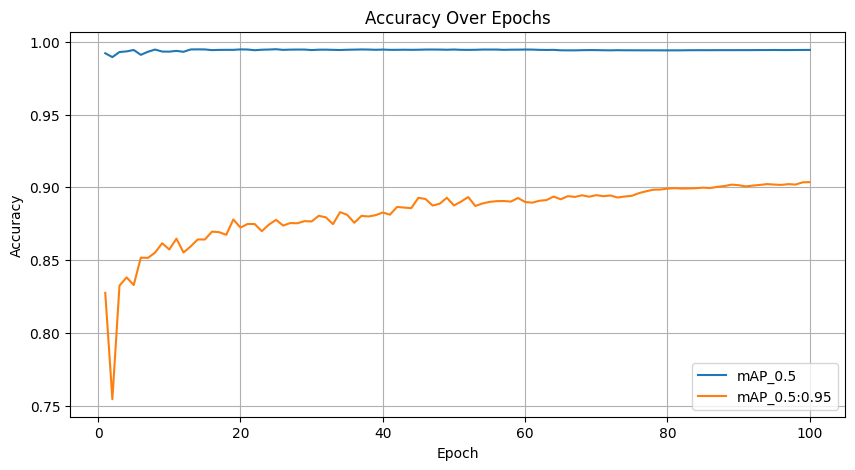

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
results = pd.read_csv('./results.csv')
results.columns = results.columns.str.strip()  

# Extract epochs and accuracy metrics
epochs = results.index + 1  
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5 # trùng với thực tế 50% thì đúng
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # MAP at IoU=0.5:0.95

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP_0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP_0.5:0.95')
plt.xlabel('Epoch');   plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

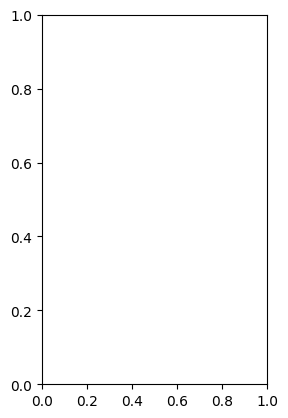

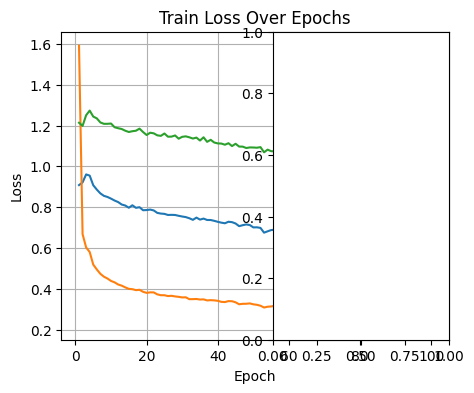

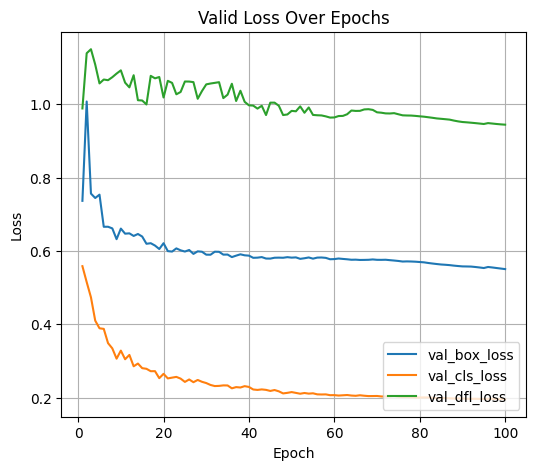

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
results = pd.read_csv('./results.csv')
results.columns = results.columns.str.strip()  

# Extract epochs and train/box_loss,train/cls_loss,train/dfl_loss // val/box_loss,val/cls_loss,val/dfl_loss
epochs = results.index + 1  
box_loss = results['train/box_loss']  
cls_loss = results['train/cls_loss']  
dfl_loss = results['train/dfl_loss']  
val_box_loss = results['val/box_loss']
val_cls_loss = results['val/cls_loss']
val_dfl_loss = results['val/dfl_loss']

plt.subplot(1, 2, 1)
plt.figure(figsize=(5, 4))
plt.plot(epochs, box_loss, label='box_loss')
plt.plot(epochs, cls_loss, label='cls_loss') 
plt.plot(epochs, dfl_loss, label='dfl_loss')
plt.xlabel('Epoch');   plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.figure(figsize=(6, 5))
plt.plot(epochs, val_box_loss, label='val_box_loss')
plt.plot(epochs, val_cls_loss, label='val_cls_loss')
plt.plot(epochs, val_dfl_loss, label='val_dfl_loss')
plt.xlabel('Epoch');   plt.ylabel('Loss')
plt.title('Valid Loss Over Epochs')
plt.legend(loc="lower right")
plt.grid(True)
